In [1]:
%matplotlib inline

In [2]:
# This notebook calculates the changes in the degree of glaciation of each catchment
# We read glacier outlines from Hannesdottir et al, for 1890-2019, and calculate the percentage and total km2 of glaciation 
# for each catchment

In [3]:
import geopandas as gpd
import pandas as pds
from pathlib import Path
import os
import geopandas as gpd
from shapely.geometry import Polygon, mapping
import matplotlib.pyplot as plt
import numpy as np
pds.options.display.max_rows = 999

def linestring_to_polygon(gdf,orig_gdf):
    # This function converts glacier outline linestrings to polygons
    # Thanks to Carlos Encisco, https://stackoverflow.com/questions/2964751/how-to-convert-a-geos-multilinestring-to-polygon
    # geom = [x for x in gdf.geometry]
    all_coords = mapping(gdf.geometry)['coordinates']
    lats = [x[1] for x in all_coords]
    lons = [x[0] for x in all_coords]
    polyg = Polygon(zip(lons, lats))
    return gpd.GeoDataFrame(index=[0], crs=orig_gdf.crs, geometry=[polyg])

In [4]:
# Read watersheds and gauges
watersheds = gpd.read_file(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\catchments.shp')
watersheds.index = watersheds['id']
watersheds = watersheds.sort_index()

gauges = gpd.read_file(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\gauges.shp')
gauges.index = gauges['id']
gauges = gauges.drop(columns=['id'])
gauges = gauges.sort_index()

# Read basemap for Iceland (used for plotting)
bmap = gpd.read_file(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\stanford-xz811fy7881-shapefile\island_isn93.shp')

In [6]:
# Define the paths to the glacier outline shapefiles
glacier_filenames = dict()
path = Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\glacier_outline_1890_2019_hh_Aug2021\jökla-útlínur")
for year in [1890,1945,1970,2000,2014,2017,2019]: #2011,2012 #2007,2008 2010,
    if year in [1970,2000]:
        fname = '%ss_glacier_outlines.shp' % year
    else:
        fname = '%s_glacier_outlines.shp' % year
    glacier_filenames[year] = os.path.join(path,fname)
# Note: Years 1890, 2000, 2014, 2017 and 2019 contain all glaciers. 1945 and 1970 only contain the largest glaciers.

# We create a pandas dataframe to insert results
results_percentage = pds.DataFrame(index=watersheds.index)
results_km2 = pds.DataFrame(index=watersheds.index)

In [5]:
# Loop over each year and calculate the glacierized area and percentage of catchment under glacier
for year, filename in glacier_filenames.items():
    print(year)
    # Read in the glacier geodataframe for this year
    glaciers = gpd.read_file(filename)
    # We select only the lines that are classified as glacier outlines
    glacier_bounds = glaciers[glaciers['catagory']=='glac_bound']
    polygon_geoms = []
    for i in glacier_bounds.index:
        # Blöndujökull á Hornströndum (i=559): Geometrían er biluð fyrir 1890
        if i == 559 and year == 1890:
            glacier_bounds = glacier_bounds.drop(i)
            continue
        # Some glacier bounds have invalid geometries (nonetype)
        # We convert the linestring to polygon if the geometry is valid
        # If not, we remove the corresponding row in glacier_bounds
        # This actually just happens for id. 824 in 2000 
        if glacier_bounds.loc[i].geometry:
            polygon_geoms.append(linestring_to_polygon(glacier_bounds.loc[i],glacier_bounds).values[0][0])
        else:
            glacier_bounds = glacier_bounds.drop(i)
            print('Glacier bound id. %s dropped for %s' %(i,year))
            
    # Update the geometry of glacier_bounds with the corrected geometry
    glacier_bounds = glacier_bounds.set_geometry(polygon_geoms) 
    glaciers = glacier_bounds
    
    # Calculate the intersection between the catchments and glaciers
    catchments_glaciers = gpd.overlay(watersheds, glaciers, how='intersection')

    # Calculate the intersection area between each catchment and glacier
    catchments_glaciers['intersection_area'] = catchments_glaciers.geometry.area 

    # Calculate the total area of each catchment
    watersheds['catchment_area'] = watersheds.geometry.area

    # Calculate the total glacier area within each catchment
    grouped = catchments_glaciers.groupby('id')['intersection_area'].sum()

    # Sort both dataframes so that the percentage calculation is correct
    grouped = grouped.sort_index() 
    watersheds = watersheds.sort_index()

    watersheds['glacier_area'] = grouped
    # watersheds = watersheds.set_index('id') 
    # Calculate the percentage of area of each catchment covered by glaciers
    watersheds['glacier_percentage'] = (watersheds['glacier_area'] / watersheds['catchment_area']) * 100

    # watersheds['glacier_percentage'] = 100 * watersheds['glacier_area'].values / watersheds['catchment_area'].values
    results_percentage[year] = watersheds['glacier_percentage']
    results_km2[year] = watersheds['glacier_area']/1e6

1890
1945
1970
2000
Glacier bound id. 824 dropped for 2000
2014
2017
2019


In [6]:
# Small glaciers in North-Iceland are not represented in the outlines in 1945 or 1970 for the following gauges:
listi = ['V321','V51','V517','V92']
app = []
for l in listi:
    app.append(gauges[gauges['st_numer'] == l].index[0]) #,'V51','V517','V92']]

# We set the corresponding glacier percentages in the results dataframe as nans    
for i in app:
    results_km2.loc[i][[1945,1970]] = np.nan
    results_percentage.loc[i][[1945,1970]] = np.nan

In [7]:
# We set the glacier percentage and area for watershed id. 26 as 0 since the percentage is extremely low
results_km2.loc[26] = np.nan
results_percentage.loc[26] = np.nan

In [8]:
# If there's a NaN for years where all glaciers are covered, it's supposed to be a zero
# Change this!
# So if there is a number in 1890 and a nan in years 2000, 2014, 2017 or 2019:
# It should be a zero from there on.

In [9]:
def replace_nans_with_zeros(dataframe):
    df = dataframe.copy()
    # This function replaces nan values with zeros where appropriate.
    for i in df.index:
        # If there is a valid value in 1890:
        if not np.isnan(df.loc[i][1890]):
            # If there is a nan in 2000:
            if np.isnan(df.loc[i][2000]):
                df.loc[i][[2000,2014,2017,2019]] = 0
                print('2000 onwards: ID %s' %i)
            elif np.isnan(df.loc[i][2014]):
                print('2014 onwards: ID %s' %i)
                df.loc[i][[2014,2017,2019]] = 0
            elif np.isnan(df.loc[i][2017]):
                print('2017 onwards: ID %s' %i)
                df.loc[i][[2017,2019]] = 0
            elif np.isnan(df.loc[i][2019]):
                print('2019 onwards: ID %s' %i)
                df.loc[i][[2019]] = 0
    return(df)

In [10]:
final_results_km2 = replace_nans_with_zeros(results_km2)
final_results_percentage = replace_nans_with_zeros(results_percentage)

2014 onwards: ID 1
2000 onwards: ID 8
2014 onwards: ID 24
2014 onwards: ID 29
2000 onwards: ID 34
2000 onwards: ID 107
2014 onwards: ID 1
2000 onwards: ID 8
2014 onwards: ID 24
2014 onwards: ID 29
2000 onwards: ID 34
2000 onwards: ID 107


# Perform interpolation between years with valid data:

In [12]:
def interpolate(results_dataframe):
    df = results_dataframe.copy()
    
    years = list(range(1890, 2020))
    df = df.reindex(columns=years)
    df.interpolate(method='linear', axis=1, inplace=True)
    return(df)

In [13]:
interp_final_results_km2 = interpolate(final_results_km2)
interp_final_results_percentage = interpolate(final_results_percentage)

# Percentage glaciation:

In [14]:
# We skip all catchments with less than 2% glaciation in 1959
glacier_data = interp_final_results_percentage[interp_final_results_percentage[1950]>2].transpose()

startyear = '1950'

# Subset the DataFrame to include only years from 1950 to 2019
glacier_data_1950_2019 = glacier_data.loc[startyear:'2019']

# Calculate the difference in glaciated area between 1950 and 2019 for each watershed
glacier_area_diff = glacier_data_1950_2019.iloc[-1] - glacier_data_1950_2019.iloc[0]

# Calculate the mean change in glaciated area
mean_glacier_area_diff = glacier_area_diff.mean()

print("Out of the %s catchments with more than 2%% glaciation:" % len(results_percentage[interp_final_results_percentage[1950]>2]))
print("The mean change in glaciated area from %s to 2019 is:" % startyear, mean_glacier_area_diff)
print("The median change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.median())
print("The max change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.max())
print("The min change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.min())
print(' ')
print("The mean percent glaciated area in %s is:" % startyear, glacier_data_1950_2019.iloc[0].mean())
print("The mean percent glaciated area in 2019 is:", glacier_data_1950_2019.iloc[-1].mean())

Out of the 58 catchments with more than 2% glaciation:
The mean change in glaciated area from 1950 to 2019 is: -3.2071421055989053
The median change in glaciated area from 1950 to 2019 is: -2.717740132848892
The max change in glaciated area from 1950 to 2019 is: -0.20824364809465745
The min change in glaciated area from 1950 to 2019 is: -8.940828544464978
 
The mean percent glaciated area in 1950 is: 27.39212318665527
The mean percent glaciated area in 2019 is: 24.18498108105637


# Where does the maximum percent change occur?

In [15]:
glacier_area_diff.idxmin()

47

In [16]:
glacier_area_diff.loc[47]

-8.940828544464978

In [17]:
glacier_area_diff.loc[102]

-2.0695648018448978

# Area in km2:

In [18]:
# We skip all catchments with less than 2% glaciation in 1959
glacier_data = interp_final_results_km2[interp_final_results_percentage[1950]>2].transpose()

startyear = '1950'

# Subset the DataFrame to include only years from 1950 to 2019
glacier_data_1950_2019 = glacier_data.loc[startyear:'2019']

# Calculate the difference in glaciated area between 1950 and 2019 for each watershed
glacier_area_diff = glacier_data_1950_2019.iloc[-1] - glacier_data_1950_2019.iloc[0]

# Calculate the mean change in glaciated area
mean_glacier_area_diff = glacier_area_diff.mean()
print("Out of the %s catchments with more than 2%% glaciation:" % len(results_percentage[interp_final_results_percentage[1950]>2]))
print("The mean change in glaciated area from %s to 2019 is:" % startyear, mean_glacier_area_diff)
print("The median change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.median())
print("The max change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.max())
print("The min change in glaciated area from %s to 2019 is:" % startyear, glacier_area_diff.min())
print(' ')
print("The mean percent glaciated area in %s is:" % startyear, glacier_data_1950_2019.iloc[0].mean())
print("The mean percent glaciated area in 2019 is:", glacier_data_1950_2019.iloc[-1].mean())

Out of the 58 catchments with more than 2% glaciation:
The mean change in glaciated area from 1950 to 2019 is: -35.80432469274772
The median change in glaciated area from 1950 to 2019 is: -28.433244277793563
The max change in glaciated area from 1950 to 2019 is: -0.23818967064040675
The min change in glaciated area from 1950 to 2019 is: -137.18094337262664
 
The mean percent glaciated area in 1950 is: 366.3133190435099
The mean percent glaciated area in 2019 is: 330.50899435076224


# Where does the maximum areal change occur?

In [19]:
glacier_area_diff.idxmin()

102

In [20]:
glacier_area_diff.loc[102]

-137.18094337262664

In [21]:
glacier_area_diff.loc[47]

-27.033063806615573

# The number of catchments covered by glaciers in 1950 and 2019:

In [22]:
len(results_percentage[interp_final_results_percentage[2019]>0])

62

In [23]:
len(results_percentage[interp_final_results_percentage[1950]>0])

68

In [24]:
# We save a .csv file with both single year values and interpolated values

In [25]:
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\glaciated_area_km2.csv")
interp_final_results_km2.round(3).to_csv(savepath)
savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\glaciated_area_percentage.csv")
interp_final_results_percentage.round(3).to_csv(savepath)

# Prepare calculations of topographic glacier attributes:
# Clip the watersheds by the 2019 glacier outlines:

In [7]:
# We re-use the code from above:
year = 2019
filename = glacier_filenames[year]
# Read in the glacier geodataframe for this year
glaciers = gpd.read_file(filename)
# We select only the lines that are classified as glacier outlines
glacier_bounds = glaciers[glaciers['catagory']=='glac_bound']
polygon_geoms = []
for i in glacier_bounds.index:
    # Blöndujökull á Hornströndum (i=559): Geometrían er biluð fyrir 1890
    if i == 559 and year == 1890:
        glacier_bounds = glacier_bounds.drop(i)
        continue
    # Some glacier bounds have invalid geometries (nonetype)
    # We convert the linestring to polygon if the geometry is valid
    # If not, we remove the corresponding row in glacier_bounds
    # This actually just happens for id. 824 in 2000 
    if glacier_bounds.loc[i].geometry:
        polygon_geoms.append(linestring_to_polygon(glacier_bounds.loc[i],glacier_bounds).values[0][0])
    else:
        glacier_bounds = glacier_bounds.drop(i)
        print('Glacier bound id. %s dropped for %s' %(i,year))

# Update the geometry of glacier_bounds with the corrected geometry
glacier_bounds = glacier_bounds.set_geometry(polygon_geoms) 
glaciers = glacier_bounds

In [9]:
# Calculate the intersection between the catchments and glaciers
catchments_glaciers = gpd.overlay(watersheds, glaciers, how='intersection')

# Group the catchment-glacier polygons by catchment ID
grouped = catchments_glaciers.groupby('id')['geometry'].agg(lambda x: x.unary_union)

# Create a new GeoDataFrame with catchment ID and merged catchment geometry
merged_catchments = gpd.GeoDataFrame(geometry=grouped.values, crs=watersheds.crs)
merged_catchments['id'] = grouped.index

merged_catchments.index = merged_catchments['id']
merged_catchments = merged_catchments.drop(columns=['id']) #to_file('merged_catchments.shp')
# Save the merged catchments to a shapefile
# merged_catchments.to_file('merged_catchments.shp')

<AxesSubplot:>

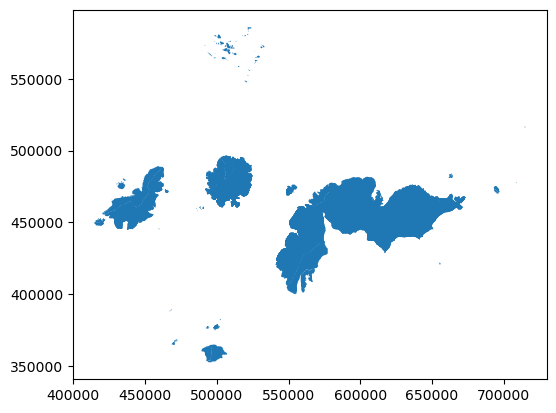

In [11]:
merged_catchments.plot() #.loc[78].geometry

# Create a watersheds shapefile where we exclude glaciers

In [19]:
# (this is for modis snow cover calculations)

In [12]:
# Calculate the intersection between the catchments and glaciers
catchments_glaciers = gpd.overlay(watersheds, glaciers, how='intersection')

# Group the catchment-glacier polygons by catchment ID
grouped = catchments_glaciers.groupby('id')['geometry'].agg(lambda x: x.unary_union)

# Create a new GeoDataFrame with catchment ID and merged catchment geometry
merged_catchments = gpd.GeoDataFrame(geometry=grouped.values, crs=watersheds.crs)
merged_catchments['id'] = grouped.index
merged_catchments.index = merged_catchments['id']
merged_catchments = merged_catchments.drop(columns=['id'])

# Calculate the difference between the merged catchments and the original watersheds
non_glacier_watersheds = watersheds.geometry.difference(merged_catchments.geometry.unary_union)

# Create a new GeoDataFrame with the non-glacier watersheds
non_glacier_watersheds_gdf = gpd.GeoDataFrame(geometry=non_glacier_watersheds, crs=watersheds.crs)

# Save the non-glacier watersheds to a shapefile
path_to_save = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\non_glacier_watersheds.shp")
non_glacier_watersheds_gdf.to_file(path_to_save)

<AxesSubplot:>

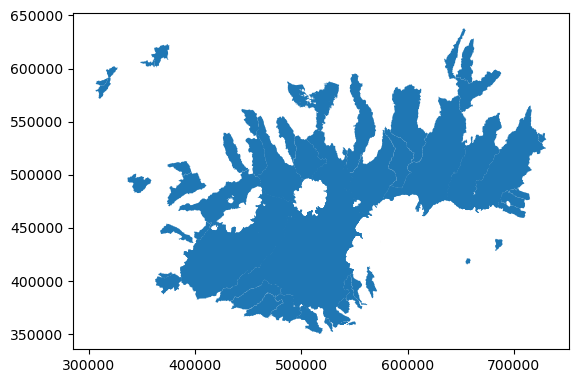

In [14]:
non_glacier_watersheds_gdf.plot()